# 회고적 EDA 
#### 대회를 끝내면서, 모델의 출력을 비교해보자.

이번 대회를 거치면서 다양한 모델과 hyper parameter를 사용해보았습니다. 대회를 진행하면서 모델간 성능을 mertric으로 비교하는 것은 많이 해보았죠. 여기서 한발 더 나아가 실제 모델의 출력 결과를 살펴보고자 합니다. 모델의 prediction과 실제 정답인 label을 비교해보면서 어떤 label 영역에서 모델이 강점을 보이는지, 또는 약점을 보이는지 분석해보겠습니다. 먼저 가장 좋은 성능을 보였던 klue/roberta-large 모델을 다시 학습시켜보면서 모델의 prediction의 변화를 살펴보고자 합니다. 그 후에는 다른 모델들도 살펴보면서 모델간의 차이를 분석해보겠습니다. 또, 우리가 데이터 증강을 하면서 모델의 prediction이 어떻게 변해가는지도 살펴볼 것입니다. 마지막으로는 데이터 통계와 함께 prediction 결과를 같이 살펴보면서 어떤 insight를 가질 수 있을지 알아보겠습니다.

그러면 학습 환경을 구축하기 위해 필요한 패키지들을 import 하겠습니다.

In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
import sklearn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from transformers import (
    AutoTokenizer, AutoConfig, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments, 
    RobertaConfig, 
    RobertaTokenizer, 
    RobertaForSequenceClassification, 
    BertTokenizer,
    RobertaModel,
    RobertaForCausalLM
)
from sklearn.model_selection import train_test_split , StratifiedKFold


from torch.utils.data import DataLoader
from load_data import *
import pickle as pickle
import numpy as np
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

대부분은 학습때 사용한 패키지들입니다. 다만 모델의 prediction과 label의 비교를 위해 confusion matrix를 활용해볼 것입니다. sklearn에 해당 기능일 제공해주는 패키지가 있습니다.

먼저 model과 tokenizer를 불러오겠습니다. 가장 먼저 살펴볼 것은 klue/roberta-lager 모델입니다.

In [2]:
MODEL_NAME = 'klue/roberta-large'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# setting model hyperparameter
model_config = AutoConfig.from_pretrained(MODEL_NAME)
model_config.num_labels = 30

model =AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=model_config)

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classif

다음에는 데이터셋을 불러옵니다. label과 num을 교환해주는 함수와 데이터를 불러와 train set과 test set으로 나눠줍니다. 여기서는 먼저 train_entity850.csv를 사용해볼 것입니다.

In [3]:
def label_to_num(label):
  num_label = []
  with open('dict_label_to_num.pkl', 'rb') as f:
    dict_label_to_num = pickle.load(f)
  for v in label:
    num_label.append(dict_label_to_num[v])
  
  return num_label

def num_to_label(label):
  """
    숫자로 되어 있던 class를 원본 문자열 라벨로 변환 합니다.
  """
  origin_label = []
  with open('dict_num_to_label.pkl', 'rb') as f:
    dict_num_to_label = pickle.load(f)
  for v in label:
    origin_label.append(dict_num_to_label[v])
  
  return origin_label

In [4]:
# load dataset
dataset = load_data("./train_entity850.csv")
target = label_to_num(dataset["label"].values)
train_dataset, dev_dataset = train_test_split(
        dataset, test_size=0.15, shuffle=True, stratify=target,
    )

train_label = label_to_num(train_dataset['label'].values)
dev_label = label_to_num(dev_dataset['label'].values)

# tokenizing dataset
tokenized_train = tokenized_dataset(train_dataset, tokenizer)
tokenized_dev = tokenized_dataset(dev_dataset, tokenizer)

# make dataset for pytorch.
RE_train_dataset = RE_Dataset(tokenized_train, train_label)
RE_dev_dataset = RE_Dataset(tokenized_dev, dev_label)

다음에는 모델에 device를 할당하는 작업을 진행합니다. 먼저 gc를 이용해 가비지콜렉팅을 진행하고, 혹시 모르니 cahce를 비워주겠습니다.

In [5]:
import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("cuda empty cache!!")

cuda empty cache!!


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
print() #성공적으로 모델을 불러왔네요!

cuda:0



다음에는 모델 학습시 필요한 metric들을 정의하겠습니다.

In [9]:
def klue_re_micro_f1(preds, labels):
    """KLUE-RE micro f1 (except no_relation)"""
    label_list = ['no_relation', 'org:top_members/employees', 'org:members',
       'org:product', 'per:title', 'org:alternate_names',
       'per:employee_of', 'org:place_of_headquarters', 'per:product',
       'org:number_of_employees/members', 'per:children',
       'per:place_of_residence', 'per:alternate_names',
       'per:other_family', 'per:colleagues', 'per:origin', 'per:siblings',
       'per:spouse', 'org:founded', 'org:political/religious_affiliation',
       'org:member_of', 'per:parents', 'org:dissolved',
       'per:schools_attended', 'per:date_of_death', 'per:date_of_birth',
       'per:place_of_birth', 'per:place_of_death', 'org:founded_by',
       'per:religion']
    no_relation_label_idx = label_list.index("no_relation")
    label_indices = list(range(len(label_list)))
    label_indices.remove(no_relation_label_idx)
    return sklearn.metrics.f1_score(labels, preds, average="micro", labels=label_indices) * 100.0

def klue_re_auprc(probs, labels):
    """KLUE-RE AUPRC (with no_relation)"""
    labels = np.eye(30)[labels]

    score = np.zeros((30,))
    for c in range(30):
        targets_c = labels.take([c], axis=1).ravel()
        preds_c = probs.take([c], axis=1).ravel()
        precision, recall, _ = sklearn.metrics.precision_recall_curve(targets_c, preds_c)
        score[c] = sklearn.metrics.auc(recall, precision)
    return np.average(score) * 100.0

def compute_metrics(pred):
  """ validation을 위한 metrics function """
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  probs = pred.predictions
    
  #cm_fig = get_confusion_matrix(preds, labels)

  # calculate accuracy using sklearn's function
  f1 = klue_re_micro_f1(preds, labels)
  auprc = klue_re_auprc(probs, labels)
  acc = accuracy_score(labels, preds) # 리더보드 평가에는 포함되지 않습니다.
    
  #wandb.log({"f1":f1, "auprc":auprc, "acc":acc})

  return {
      'micro f1 score': f1,
      'auprc' : auprc,
      'accuracy': acc,
  }

이제 마지막으로 train 함수를 정의하겠습니다. 

여기서는 간단하게 epoch의 진행에 따른 변화만을 살펴볼 것이므로 epochs만 조절하도록 코드를 살짝 변경하였습니다. 반환값은 trainer로 해당 trainer를 이용해 학습을 진행할 것입니다.

In [10]:
def train(epochs):

    # 사용한 option 외에도 다양한 option들이 있습니다.
    training_args = TrainingArguments(
            output_dir='./temp',          # output directory
            save_total_limit=5,              # number of total save model.
            save_steps=500,                 # model saving step.
            num_train_epochs=epochs,              # total number of training epochs
            learning_rate=5e-5,               # learning_rate
            per_device_train_batch_size=16,  # batch size per device during training
            per_device_eval_batch_size=16,   # batch size for evaluation
            warmup_steps=500,                # number of warmup steps for learning rate scheduler
            weight_decay=0.01,               # strength of weight decay
            logging_dir='./logss',            # directory for storing logs
            logging_steps=100,              # log saving step.
            evaluation_strategy='steps', # evaluation strategy to adopt during training
                                        # `no`: No evaluation during training.
                                        # `steps`: Evaluate every `eval_steps`.
                                        # `epoch`: Evaluate every end of epoch.
            eval_steps = 500,            # evaluation step.
            load_best_model_at_end = True ,
            lr_scheduler_type = 'cosine', #default: linear
            #metric_for_best_model = 'eval_micro f1 score', #eval_micro f1 score
        )


    trainer = Trainer(
            model=model,                         # the instantiated 🤗 Transformers model to be trained
            args=training_args,                  # training arguments, defined above
            train_dataset=RE_train_dataset,         # training dataset
            eval_dataset=RE_dev_dataset,             # evaluation dataset
            compute_metrics=compute_metrics         # define metrics function
        )
    
    return trainer

아래처럼 선언하면 1 epochs만 train을 진행하겠다는 의미입니다. 이제 학습을 시작해 봅시다!

In [11]:
trainer = train(1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
y_preds = trainer.train()

***** Running training *****
  Num examples = 33979
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2124
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: sopadenn (use `wandb login --relogin` to force relogin)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss,Micro f1 score,Auprc,Accuracy
500,1.035200,1.073222,70.625262,70.003612,0.673670
1000,0.757100,0.760233,77.280663,78.007656,0.744205
1500,0.555700,0.575405,84.432157,82.600026,0.817409
2000,0.478500,0.474983,86.540552,86.165719,0.842421


***** Running Evaluation *****
  Num examples = 5997
  Batch size = 16
Saving model checkpoint to ./temp/checkpoint-500
Configuration saved in ./temp/checkpoint-500/config.json
Model weights saved in ./temp/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5997
  Batch size = 16
Saving model checkpoint to ./temp/checkpoint-1000
Configuration saved in ./temp/checkpoint-1000/config.json
Model weights saved in ./temp/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5997
  Batch size = 16
Saving model checkpoint to ./temp/checkpoint-1500
Configuration saved in ./temp/checkpoint-1500/config.json
Model weights saved in ./temp/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5997
  Batch size = 16
Saving model checkpoint to ./temp/checkpoint-2000
Configuration saved in ./temp/checkpoint-2000/config.json
Model weights saved in ./temp/checkpoint-2000/pytorch_model.bin


Training completed. Do not fo

1 epoch만 학습을 진행합니다. 

위의 표를 보시면 점차 loss가 줄어들고 accuracy가 올라가는 모습을 확인할 수 있습니다. 학습이 잘 되어가는 것 같네요!

y_preds에는 모델의 전체적인 결과가 저장될 것입니다. 좀 더 아래에서 다시 살펴볼겁니다.

In [14]:
print(y_preds)

TrainOutput(global_step=2124, training_loss=0.9473623892681747, metrics={'train_runtime': 2165.0033, 'train_samples_per_second': 15.695, 'train_steps_per_second': 0.981, 'total_flos': 1.4906740382326716e+16, 'train_loss': 0.9473623892681747, 'epoch': 1.0})


이제 모델의 prediction과 label을 비교할 수 있게 label을 가져오겠습니다. 위에서 데이터셋을 구축하면서 이미 정의했으므로 그대로 가져오도록 하겠습니다.

In [15]:
labels = train_label

다음은 학습된 모델의 inference를 진행하겠습니다. 

우리의 1 epoch만 학습한 모델을 가지고 train dataset을 넣어 train dataset의 label과 비교해볼 것입니다. pred_answer에 우리 모델의 prediction이 저장될 것입니다.

In [16]:
def inference(model, tokenized_sent, device):
  """
    test dataset을 DataLoader로 만들어 준 후,
    batch_size로 나눠 model이 예측 합니다.
  """
  dataloader = DataLoader(tokenized_sent, batch_size=16, shuffle=False)
  model.eval()
  output_pred = []
  output_prob = []
  for i, data in enumerate(tqdm(dataloader)):
    with torch.no_grad():
      #print(data)
      outputs = model(
          input_ids=data['input_ids'].to(device),
          attention_mask=data['attention_mask'].to(device),
          token_type_ids=data['token_type_ids'].to(device)
          )

    logits = outputs[0]
    prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits, axis=-1)

    output_pred.append(result)
    output_prob.append(prob)
  
  return np.concatenate(output_pred).tolist(), np.concatenate(output_prob, axis=0).tolist()

In [17]:
pred_answer, output_prob = inference(model, RE_train_dataset, device) # model에서 class 추론
#pred_answer, output_prob = inference(model, RE_dev_dataset, device)
pred_answer = num_to_label(pred_answer) # 숫자로 된 class를 원래 문자열 라벨로 변환.

100%|██████████| 2124/2124 [08:38<00:00,  4.09it/s]


inference도 끝났습니다! 이제 바로 비교하면 될까요?

안타깝게도 모델의 prediction과 label은 숫자로 임베딩 된 상태입니다. 이대로 사람이 읽기에는 무리가 있으니 다시 label로 바꿔주도록 하겠습니다.

In [32]:
labels = num_to_label(train_label)
##labels = num_to_label(dev_label)

이제 라벨로 변환도 끝났겠다, 바로 confusion matrix를 만들어 살펴보도록 하겠습니다.

먼저 label_list를 가져와 x, y축의 ticks으로 붙이겠습니다.

In [37]:
label_list = ['no_relation', 'org:top_members/employees', 'org:members',
       'org:product', 'per:title', 'org:alternate_names',
       'per:employee_of', 'org:place_of_headquarters', 'per:product',
       'org:number_of_employees/members', 'per:children',
       'per:place_of_residence', 'per:alternate_names',
       'per:other_family', 'per:colleagues', 'per:origin', 'per:siblings',
       'per:spouse', 'org:founded', 'org:political/religious_affiliation',
       'org:member_of', 'per:parents', 'org:dissolved',
       'per:schools_attended', 'per:date_of_death', 'per:date_of_birth',
       'per:place_of_birth', 'per:place_of_death', 'org:founded_by',
       'per:religion']
len(label_list)

30

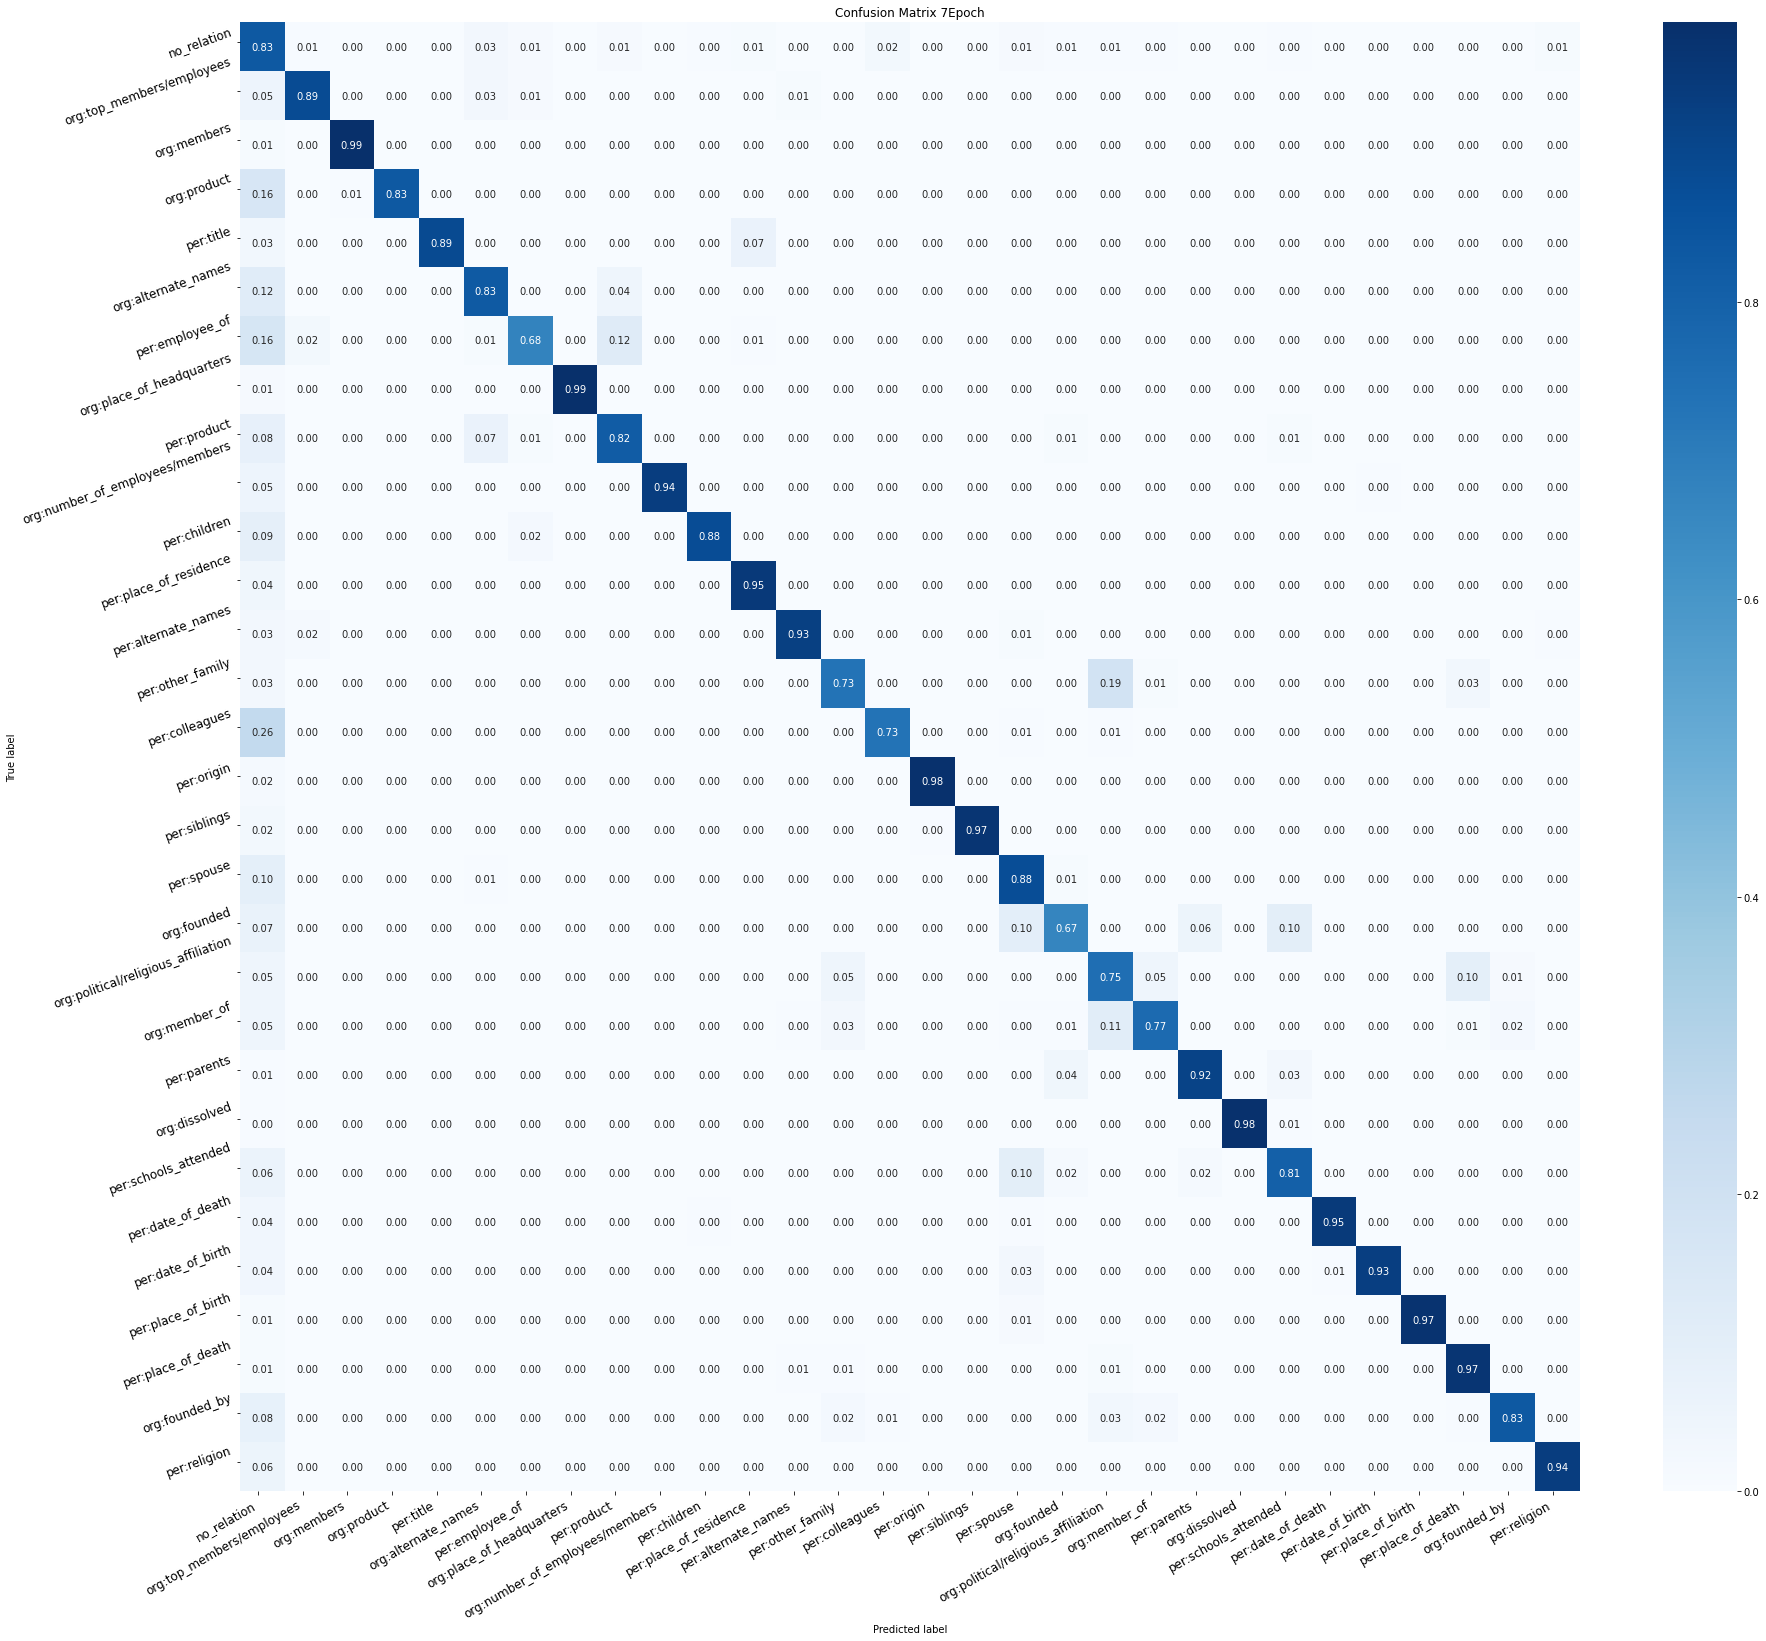

In [50]:
fig = plt.figure(figsize=(30,30))

cm = confusion_matrix(pred_answer, labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize 진행

ax = sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues")
#ax.set(title='Confusion Matrix', ylabel='True label', xlabel='Predicted label', xticks=label_list, yticks=label_list)

ticks = np.arange(0.4, 30, 1)

plt.title('Confusion Matrix 7Epoch')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(ticks, label_list, rotation=20, size=12)
plt.yticks(ticks, label_list, rotation=20, size=12)

fig.autofmt_xdate(rotation=30)

plt.show()

네 이렇게 한 에폭만 학습시킨 모델의 inference 결과를 보실 수 있습니다. 

대체로 잘 맞추는 편이지만, 모델이 no_relation이라고 잘못된 prediction을 내놓는 경향이 있다는 것을 확인할 수 있습니다. 아마도 이는 데이터가 no_relation에 아주 크게 편향되어 있기 때문일 것입니다.

그밖에도 몇가지 잘 예측하지 못 하는 경우가 존재하는데요.

- per:other_family를 org:founded로 잘못 예측
- org:political/religious_affiliation와 org:member_of를 per:alternate_names로 잘못 예측
- per:employee_of를 per:product로 잘못 예측

등이 존재합니다. 또 정답률 자체를 살펴보면 

- per:employee_of
- per:other_family
- per:colleagues
- org:founded
- org:political/religious_affiliation
- org:member_of
- per:schools_attended

처럼 몇가지 label의 경우에는 정답률이 낮은 모습을 볼 수 있습니다. 왜 이런 일이 발생한 것일까요? 데이터의 분포를 한번 살펴보도록 하겠습니다.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from ast import literal_eval
from collections import defaultdict

In [28]:
df = pd.read_csv('./train_entity850.csv')
#df.head()

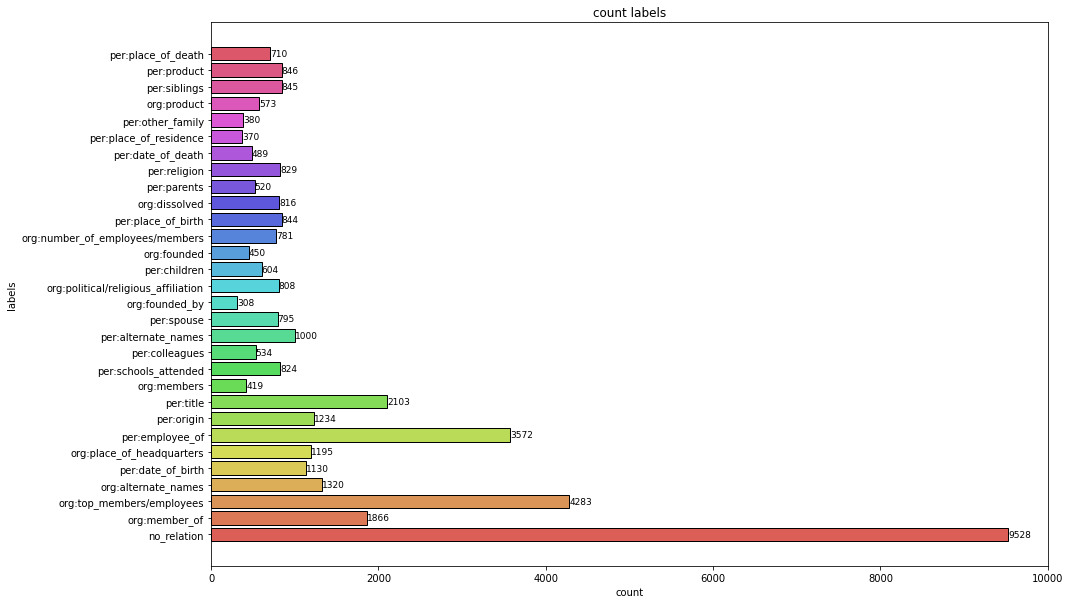

In [29]:
labels_counter = defaultdict(int)
for data in df['label']:
    labels_counter[data] += 1
# print(labels_counter)

%matplotlib inline
y = np.arange(30)
# 데이터
ratio = [value for value in labels_counter.values()]
labels = [key for key in labels_counter.keys()]
colors = sns.color_palette('hls',len(labels)) ## 색상 지정

# 시각화
fig = plt.figure(figsize=(15,10))
plt.barh(labels, ratio, color=colors, edgecolor='black') ## 바 차트 출력
plt.title("count labels")
plt.xlabel('count')
plt.ylabel('labels')

for i, v in enumerate(labels):
    str_val = "%d" % ratio[i]
    plt.text(ratio[i], v, str_val, fontsize=9,horizontalalignment='left',verticalalignment='center')

plt.show()

confusion matrix 상 모델이 잘 맞추지 못 하는 label은 아래와 같았습니다.

- per:employee_of
- per:other_family
- per:colleagues
- org:founded
- org:political/religious_affiliation
- org:member_of
- per:schools_attended

해당 label의 데이터셋 분포를 한번 살펴볼까요?


In [66]:
cond = df['label'] == 'per:employee_of'
print("per:employee_of: %.2f %%" % (len(df.loc[cond]) / len(df) * 100))
cond = df['label'] == 'per:other_family'
print("per:other_family: %.2f %%" % (len(df.loc[cond]) / len(df) * 100))
cond = df['label'] == 'per:colleagues'
print("per:colleagues: %.2f %%" % (len(df.loc[cond]) / len(df) * 100))
cond = df['label'] == 'org:founded'
print("org:founded: %.2f %%" % (len(df.loc[cond]) / len(df) * 100))
cond = df['label'] == 'org:political/religious_affiliation'
print("org:political/religious_affiliation: %.2f %%" % (len(df.loc[cond]) / len(df) * 100))
cond = df['label'] == 'org:member_of'
print("org:member_of: %.2f %%" % (len(df.loc[cond]) / len(df) * 100))
cond = df['label'] == 'per:schools_attended'
print("per:schools_attended: %.2f %%" % (len(df.loc[cond]) / len(df) * 100))

per:employee_of: 8.94 %
per:other_family: 0.95 %
per:colleagues: 1.34 %
org:founded: 1.13 %
org:political/religious_affiliation: 2.02 %
org:member_of: 4.67 %
per:schools_attended: 2.06 %


![](image2.png)

![](image.png)

위의 그래프는 원본 train.csv파일의 분포이고, 아래의 그래프는 augmentation 과정을 거친 train850.csv입니다.

증강을 거쳤지만 여전히 데이터가 불균형한 모습을 볼 수 있는데요. 저희가 앞서 주목했던 label은 화살표로 표시했습니다. 그 외에도 Confusion matrix에서 정확도가 비교적 낮은 label들도 그래프에서 찾아보면 불균형한 데이터였다는 사실을 알 수 있습니다. 특히 no_relation의 경우에는 숫자가 너무 많기 때문에, 모델이 잘 모르겠는 경우에는 전부 no_relation으로 출력했다는 사실을 알 수 있습니다.

즉, 부족한 데이터에 대해 augmentation을 통한 증강도 중요하지만 이후 데이터의 분포를 다시 살펴보고 불균형을 해결해는 sampling 작업이 필요한 것입니다.

### xlm-roberta-large

이번에는 다른 모델을 사용해보겠습니다.

In [89]:
MODEL_NAME = 'xlm-roberta-large'
# setting model hyperparameter
#model_config = AutoConfig.from_pretrained('./config.json')
#model_config.num_labels = 30
#tokenizer = AutoTokenizer.from_pretrained('./tokenizer.json')

model_config = AutoConfig.from_pretrained(MODEL_NAME)
model_config.num_labels = 30
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model =AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=model_config)
#print(model)

loading configuration file https://huggingface.co/xlm-roberta-large/resolve/main/config.json from cache at /opt/ml/.cache/huggingface/transformers/4d7a1550c9ab8701667bc307a1213c040fcc06dc87a5e4994e72aecc0d7e0337.842c7737719967568f4691849854475018d6cf7ce21f52576bb6e0d10091bd3c
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

Could not locate

In [91]:
# load dataset
dataset = load_data("./train_entity850.csv")
target = label_to_num(dataset["label"].values)
train_dataset, dev_dataset = train_test_split(
        dataset, test_size=0.15, shuffle=True, stratify=target,
    )

train_label = label_to_num(train_dataset['label'].values)
dev_label = label_to_num(dev_dataset['label'].values)

# tokenizing dataset
tokenized_train = tokenized_dataset(train_dataset, tokenizer)
tokenized_dev = tokenized_dataset(dev_dataset, tokenizer)

# make dataset for pytorch.
RE_train_dataset = RE_Dataset(tokenized_train, train_label)
RE_dev_dataset = RE_Dataset(tokenized_dev, dev_label)

토크나이저를 잠깐 살펴보겠습니다.

In [101]:
# 문장 2개 토큰화
MAX_LEN = 12 

sentence1 = '안녕하세요'
sentence2 = '반갑습니다.'

encoded_dict = tokenizer.encode_plus(
            sentence1, sentence2,      
            add_special_tokens = True,
            max_length = MAX_LEN,     
            pad_to_max_length = True,
            return_attention_mask = True,   
            return_tensors = 'pt' 
       )


encoded_dict

{'input_ids': tensor([[     0, 107687,      2,      2,  20451,  54272,  16367,      5,      2,
              1,      1,      1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])}

In [102]:
input_ids = encoded_dict['input_ids'][0]
att_mask = encoded_dict['attention_mask'][0]

print(input_ids)
print(att_mask)

tensor([     0, 107687,      2,      2,  20451,  54272,  16367,      5,      2,
             1,      1,      1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])


In [103]:
# 토큰 디코드
input_ids = encoded_dict['input_ids'][0]
tokenizer.decode(input_ids,
                skip_special_tokens=False)

'<s> 안녕하세요</s></s> 반갑습니다.</s><pad><pad><pad>'

이제 본격적으로 다시 학습을 준비하겠습니다. mertric에서 차이가 있기 때문에 기존과는 조금 다른 코드를 사용합니다.

In [ ]:
# xlm-roberta-large를 위한 metric 재정의
def compute_metrics(pred):
  """ validation을 위한 metrics function """
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  probs = pred.predictions
    
  #cm_fig = get_confusion_matrix(preds, labels)

  # calculate accuracy using sklearn's function
  f1 = klue_re_micro_f1(preds, labels)
  auprc = klue_re_auprc(probs, labels)
  acc = accuracy_score(labels, preds) # 리더보드 평가에는 포함되지 않습니다.
    
  #wandb.log({"f1":f1, "auprc":auprc, "acc":acc})

  return {
      'micro f1 score': f1,
      'auprc' : auprc,
      'accuracy': acc,
  }

In [109]:
from datasets import load_dataset, load_metric
metric = load_metric("glue", "qnli")

In [110]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [111]:
# 사용한 option 외에도 다양한 option들이 있습니다.
training_args = TrainingArguments(
            output_dir='./temp',          # output directory
            save_total_limit=5,              # number of total save model.
            save_steps=500,                 # model saving step.
            num_train_epochs=1,              # total number of training epochs
            learning_rate=5e-5,               # learning_rate
            per_device_train_batch_size=16,  # batch size per device during training
            per_device_eval_batch_size=16,   # batch size for evaluation
            warmup_steps=500,                # number of warmup steps for learning rate scheduler
            weight_decay=0.01,               # strength of weight decay
            logging_dir='./logss',            # directory for storing logs
            logging_steps=100,              # log saving step.
            evaluation_strategy='steps', # evaluation strategy to adopt during training
                                        # `no`: No evaluation during training.
                                        # `steps`: Evaluate every `eval_steps`.
                                        # `epoch`: Evaluate every end of epoch.
            eval_steps = 500,            # evaluation step.
            load_best_model_at_end = True ,
            lr_scheduler_type = 'cosine', #default: linear
            #metric_for_best_model = 'eval_micro f1 score', #eval_micro f1 score
    )


trainer = Trainer(
            model=model,                         # the instantiated 🤗 Transformers model to be trained
            args=training_args,                  # training arguments, defined above
            train_dataset=RE_train_dataset,         # training dataset
            eval_dataset=RE_dev_dataset,             # evaluation dataset
            compute_metrics=compute_metrics         # define metrics function
        )

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [112]:
import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("cuda empty cache!!")

cuda empty cache!!


In [113]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
print() #성공적으로 모델을 불러왔네요!

cuda:0



In [114]:
#trainer = train(1)

In [115]:
y_preds = trainer.train()

***** Running training *****
  Num examples = 33979
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2124
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Accuracy
500,0.754500,0.881432,0.729365
1000,0.863500,0.827916,0.745539
1500,0.664500,0.639743,0.782058
2000,0.557600,0.519814,0.824746


***** Running Evaluation *****
  Num examples = 5997
  Batch size = 16
Saving model checkpoint to ./temp/checkpoint-500
Configuration saved in ./temp/checkpoint-500/config.json
Model weights saved in ./temp/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5997
  Batch size = 16
Saving model checkpoint to ./temp/checkpoint-1000
Configuration saved in ./temp/checkpoint-1000/config.json
Model weights saved in ./temp/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5997
  Batch size = 16
Saving model checkpoint to ./temp/checkpoint-1500
Configuration saved in ./temp/checkpoint-1500/config.json
Model weights saved in ./temp/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5997
  Batch size = 16
Saving model checkpoint to ./temp/checkpoint-2000
Configuration saved in ./temp/checkpoint-2000/config.json
Model weights saved in ./temp/checkpoint-2000/pytorch_model.bin


Training completed. Do not fo

학습이 끝났습니다. 마찬가지로 1 에폭만 진행했습니다. 이제 inference를 찍어서 한번 비교해보도록 하겠습니다.

In [118]:
def inference(model, tokenized_sent, device):
  """
    test dataset을 DataLoader로 만들어 준 후,
    batch_size로 나눠 model이 예측 합니다.
  """
  dataloader = DataLoader(tokenized_sent, batch_size=16, shuffle=False)
  model.eval()
  output_pred = []
  output_prob = []
  for i, data in enumerate(tqdm(dataloader)):
    with torch.no_grad():
      #print(data)
      outputs = model(
          input_ids=data['input_ids'].to(device),
          attention_mask=data['attention_mask'].to(device),
          #token_type_ids=data['token_type_ids'].to(device) 여기서는 지워줍니다.
          )

    logits = outputs[0]
    prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits, axis=-1)

    output_pred.append(result)
    output_prob.append(prob)
  
  return np.concatenate(output_pred).tolist(), np.concatenate(output_prob, axis=0).tolist()

In [119]:
pred_answer, output_prob = inference(model, RE_train_dataset, device) # model에서 class 추론
#pred_answer, output_prob = inference(model, RE_dev_dataset, device)
pred_answer = num_to_label(pred_answer) # 숫자로 된 class를 원래 문자열 라벨로 변환.

100%|██████████| 2124/2124 [09:00<00:00,  3.93it/s]


In [123]:
labels = num_to_label(train_label)

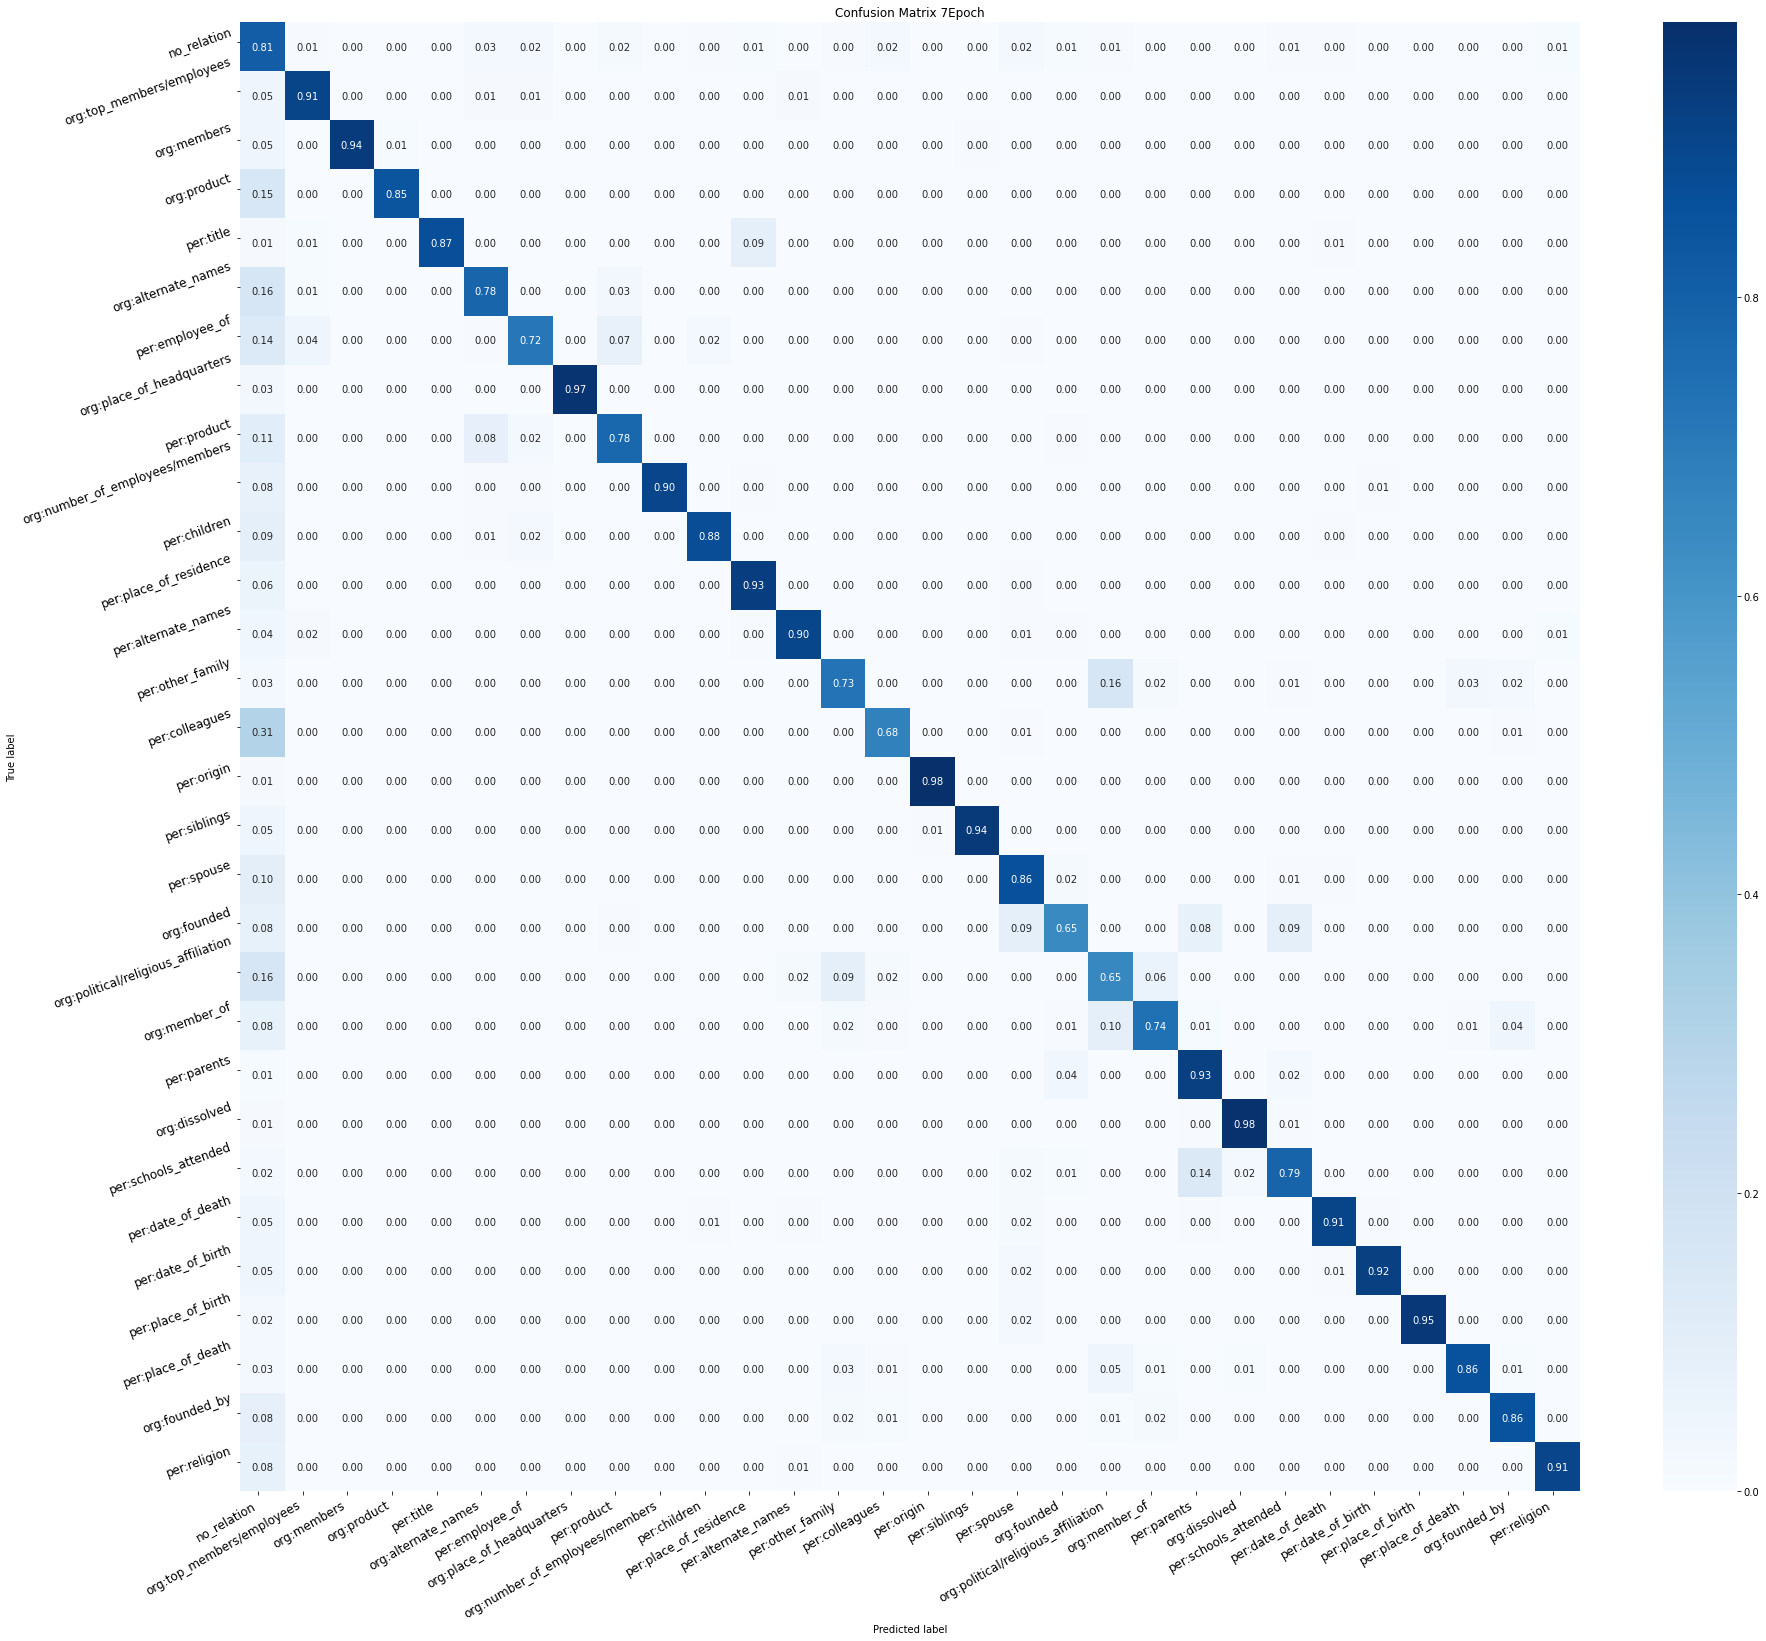

In [124]:
fig = plt.figure(figsize=(30,30))

cm = confusion_matrix(pred_answer, labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize 진행

ax = sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues")
#ax.set(title='Confusion Matrix', ylabel='True label', xlabel='Predicted label', xticks=label_list, yticks=label_list)

ticks = np.arange(0.4, 30, 1)

plt.title('Confusion Matrix 7Epoch')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(ticks, label_list, rotation=20, size=12)
plt.yticks(ticks, label_list, rotation=20, size=12)

fig.autofmt_xdate(rotation=30)

plt.show()

klue/roberta-large와 유사지만 확률값은 조금 다른 것을 볼 수 있습니다. 이처럼 각 모델마다 결과값이 다르므로 앙상블을 진행하면 모델이 확신하지 못 하는 label (확률이 낮은) case에 대해서는 일종의 집단지성을 발휘하여 추론하는 것입니다. 여기서는 비슷한 roberta 계열의 모델만을 비교했지만, bert나 gpt처럼 아예 다른 모델을 사용한다면 더욱 다양성이 많이 반영된 모델을 앙상블 할 수 있게 됩니다.

